In [504]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data_cleaner as dc
import data_modeler as dm
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import importlib
importlib.reload(dm)
importlib.reload(dc)
%matplotlib inline

In [505]:
df = dm.load_dataframe()
df

,year,pct,cmplnts,population,arrests,stops,stop_arrests,policy,nonstop_arrests,crimerate,...,log_nonstop_arrestrate,log_stoprate,log_stop_arrestrate,log_arrestrate,log_nonstop_arrests,log_arrests,log_population,log_stops,log_stop_arrests,log_cmplnts
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0,1,4787.0,99.191650,...,4.273769,3.626553,1.198273,4.318902,8.473659,8.518792,11.107645,7.826443,5.398163,8.796944
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0,1,5133.0,94.182576,...,4.343556,3.657591,1.272381,4.388879,8.543446,8.588769,11.107645,7.857481,5.472271,8.745125
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0,1,4690.0,88.408644,...,4.253298,3.602319,1.360792,4.307253,8.453188,8.507143,11.107645,7.802209,5.560682,8.681860
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0,1,5368.0,89.308478,...,4.388321,3.995995,1.170748,4.427591,8.588211,8.627482,11.107645,8.195885,5.370638,8.691986
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0,1,5290.0,94.287557,...,4.373683,3.823990,1.041857,4.408788,8.573574,8.608678,11.107645,8.023880,5.241747,8.746239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0,0,1485.0,29.163946,...,2.717876,1.186147,-0.336799,2.763937,7.303170,7.349231,11.493049,5.771441,4.248495,7.958227
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0,0,1409.0,27.868451,...,2.665342,0.258893,-1.184097,2.686410,7.250636,7.271704,11.493049,4.844187,3.401197,7.912789
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0,0,1536.0,27.011588,...,2.751643,-0.085484,-1.119558,2.772262,7.336937,7.357556,11.493049,4.499810,3.465736,7.881560
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0,0,1579.0,26.001714,...,2.779253,-0.458160,-1.449800,2.793714,7.364547,7.379008,11.493049,4.127134,3.135494,7.843456


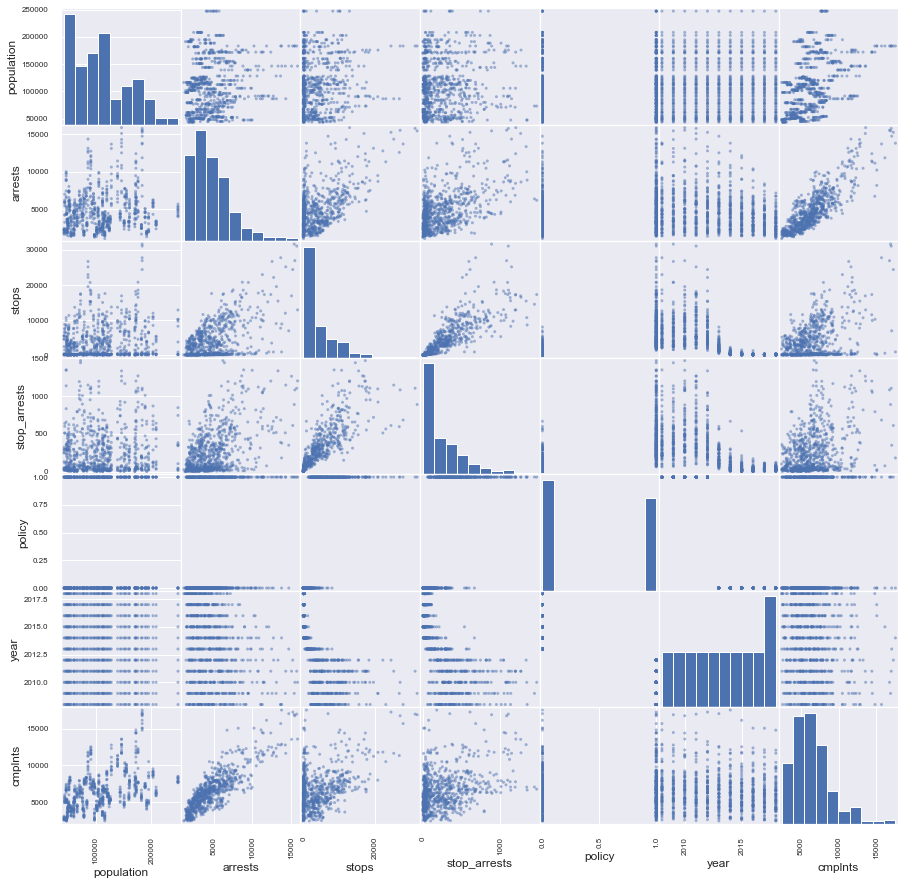

In [427]:
sns.set(rc={'figure.figsize':(15,15)})
pd.plotting.scatter_matrix(df[['population','arrests','stops','stop_arrests','policy','year','cmplnts']]);


As we can see, there is extremely high correlation between complaints and arrests, and there is a very high correlation between stops and stop arrests. Other data is well correlated as well. Also our data is heavily skewed.

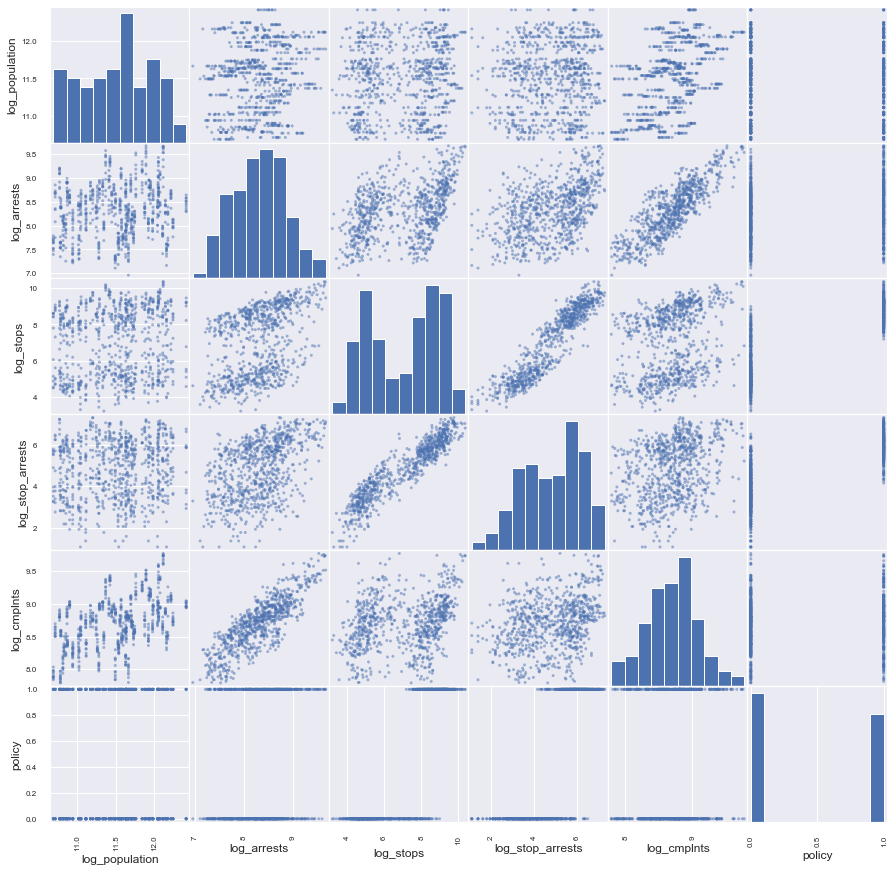

In [508]:
sns.set(rc={'figure.figsize':(15,15)})
pd.plotting.scatter_matrix(df[['log_population','log_arrests','log_stops','log_stop_arrests','log_cmplnts','policy']]);

With log transform we see much less skew. The two groupings of the stops and stop_arrests now appear, strongly correlated with the policy variable.

## Basic linear model

In [250]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

<module 'data_modeler' from '/Users/brad/Documents/Scripts/flatiron/fis-mod4-project/data_modeler.py'>

Look at base features:

In [463]:
x_vars = ['population', 'cmplnts', 'stops', 'stop_arrests', 'policy', 'normal_year']
results = dm.run_ols(df, x_vars, 'nonstop_arrests')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        nonstop_arrests   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     594.7
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          8.96e-259
Time:                        21:24:24   Log-Likelihood:                -5423.4
No. Observations:                 651   AIC:                         1.086e+04
Df Residuals:                     644   BIC:                         1.089e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1436.8301    252.403      5.693      0.000     941.198    1932.462
population      -0.0148      0.001    -16.008      0.000      -0.017      -0.013
cmplnts          0.8820      0.021     42.752      0.000       0.841       0.922
stops            0.1019      0.016      6.293      0.000       0.070       0.134
stop_arrests     0.5528      0.265      2.086      0.037       0.032       1.073
policy       -1489.4908    180.136     -8.269      0.000   -1843.215   -1135.766
normal_year   -147.1428     25.481     -5.775      0.000    -197.179     -97.107
==============================================================================
Omnibus:                       46.494   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.133
Skew:                           0.566   Prob(JB):                     7.19e-15
Kurtosis:                       4.059   Cond. No.                     8.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [510]:
x_vars = ['log_population', 'log_cmplnts', 'log_stops', 'log_stop_arrests', 'policy', 'normal_year']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrests')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_nonstop_arrests   R-squared:                       0.830
Model:                             OLS   Adj. R-squared:                  0.828
Method:                  Least Squares   F-statistic:                     524.1
Date:                 Wed, 04 Dec 2019   Prob (F-statistic):          5.66e-244
Time:                         23:34:04   Log-Likelihood:                 53.529
No. Observations:                  651   AIC:                            -93.06
Df Residuals:                      644   BIC:                            -61.71
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0857      0.248      4.369      0.000       0.598       1.574
log_population      -0.4123      0.022    -18.346      0.000      -0.456      -0.368
log_cmplnts          1.3248      0.029     45.718      0.000       1.268       1.382
log_stops            0.0843      0.019      4.543      0.000       0.048       0.121
log_stop_arrests    -0.0046      0.018     -0.253      0.800      -0.040       0.031
policy              -0.2773      0.039     -7.076      0.000      -0.354      -0.200
normal_year         -0.0093      0.007     -1.364      0.173      -0.023       0.004
==============================================================================
Omnibus:                       11.335   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.862
Skew:                           0.211   Prob(JB):                     0.000977
Kurtosis:                       3.576   Cond. No.                         507.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [461]:
x_vars = ['stoprate','stop_arrestrate','crimerate','policy','normal_year','population']
dm.run_ols(df, x_vars, 'nonstop_arrestrate')['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     nonstop_arrestrate   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     639.3
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          2.22e-267
Time:                        21:24:13   Log-Likelihood:                -2549.9
No. Observations:                 651   AIC:                             5114.
Df Residuals:                     644   BIC:                             5145.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.2464      3.659     -0.341      0.733      -8.432       5.939
stoprate            0.0943      0.020      4.695      0.000       0.055       0.134
stop_arrestrate     0.7567      0.275      2.747      0.006       0.216       1.298
crimerate           0.8953      0.022     39.899      0.000       0.851       0.939
policy            -15.7146      2.154     -7.295      0.000     -19.945     -11.485
normal_year        -1.5881      0.306     -5.194      0.000      -2.189      -0.988
population       3.844e-06   1.21e-05      0.318      0.751   -1.99e-05    2.76e-05
==============================================================================
Omnibus:                      141.140   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.988
Skew:                           0.868   Prob(JB):                    7.48e-157
Kurtosis:                       7.847   Cond. No.                     1.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [515]:
x_vars = ['log_stoprate','log_stop_arrestrate','log_crimerate','policy','normal_year','log_population']
dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_nonstop_arrestrate   R-squared:                       0.876
Model:                                OLS   Adj. R-squared:                  0.875
Method:                     Least Squares   F-statistic:                     758.6
Date:                    Wed, 04 Dec 2019   Prob (F-statistic):          4.32e-288
Time:                            23:35:39   Log-Likelihood:                 29.045
No. Observations:                     651   AIC:                            -44.09
Df Residuals:                         644   BIC:                            -12.74
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.6312      0.395     -4.135      0.000      -2.406      -0.857
log_stoprate            0.0689      0.019      3.622      0.000       0.032       0.106
log_stop_arrestrate     0.0073      0.019      0.390      0.697      -0.030       0.044
log_crimerate           1.3157      0.030     43.273      0.000       1.256       1.375
policy                 -0.2692      0.041     -6.552      0.000      -0.350      -0.189
normal_year            -0.0136      0.007     -1.937      0.053      -0.027       0.000
log_population         -0.0065      0.027     -0.244      0.807      -0.059       0.046
==============================================================================
Omnibus:                       10.352   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.104
Skew:                           0.211   Prob(JB):                      0.00235
Kurtosis:                       3.517   Cond. No.                         606.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A dramatic improvement in the model. RSS is higher, skew and kurtosis are much improved. Multicollinearity reduced as well.

In [560]:
x_vars = ['log_crimerate','log_stoprate','policy']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_nonstop_arrestrate   R-squared:                       0.872
Model:                                OLS   Adj. R-squared:                  0.872
Method:                     Least Squares   F-statistic:                     1475.
Date:                    Wed, 04 Dec 2019   Prob (F-statistic):          8.99e-289
Time:                            23:47:12   Log-Likelihood:                 21.726
No. Observations:                     651   AIC:                            -35.45
Df Residuals:                         647   BIC:                            -17.54
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8835      0.094    -20.107      0.000      -2.067      -1.700
log_crimerate     1.3265      0.024     55.620      0.000       1.280       1.373
log_stoprate      0.0838      0.010      8.217      0.000       0.064       0.104
policy           -0.2330      0.037     -6.324      0.000      -0.305      -0.161
==============================================================================
Omnibus:                       10.809   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.644
Skew:                           0.252   Prob(JB):                      0.00296
Kurtosis:                       3.418   Cond. No.                         52.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try to reduce the covariance of stops and crimes:

In [563]:
df['stops_per_crimes'] = df['stops'] / df['cmplnts']
df['log_stops_per_crimes'] = df['stops_per_crimes'].apply(np.log).copy()

In [567]:
x_vars = ['log_crimerate','log_stops_per_crimes','policy']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_nonstop_arrestrate   R-squared:                       0.877
Model:                                OLS   Adj. R-squared:                  0.876
Method:                     Least Squares   F-statistic:                     1531.
Date:                    Wed, 04 Dec 2019   Prob (F-statistic):          2.36e-293
Time:                            23:50:47   Log-Likelihood:                 23.624
No. Observations:                     651   AIC:                            -39.25
Df Residuals:                         647   BIC:                            -21.33
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.8531      0.093    -19.831      0.000      -2.037      -1.670
log_crimerate            1.4085      0.021     66.590      0.000       1.367       1.450
log_stops_per_crimes     0.0890      0.010      8.672      0.000       0.069       0.109
policy                  -0.2475      0.037     -6.752      0.000      -0.319      -0.176
==============================================================================
Omnibus:                       10.026   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.279
Skew:                           0.221   Prob(JB):                      0.00355
Kurtosis:                       3.470   Cond. No.                         48.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model seems to be improved. Did it improve our covariance problem?

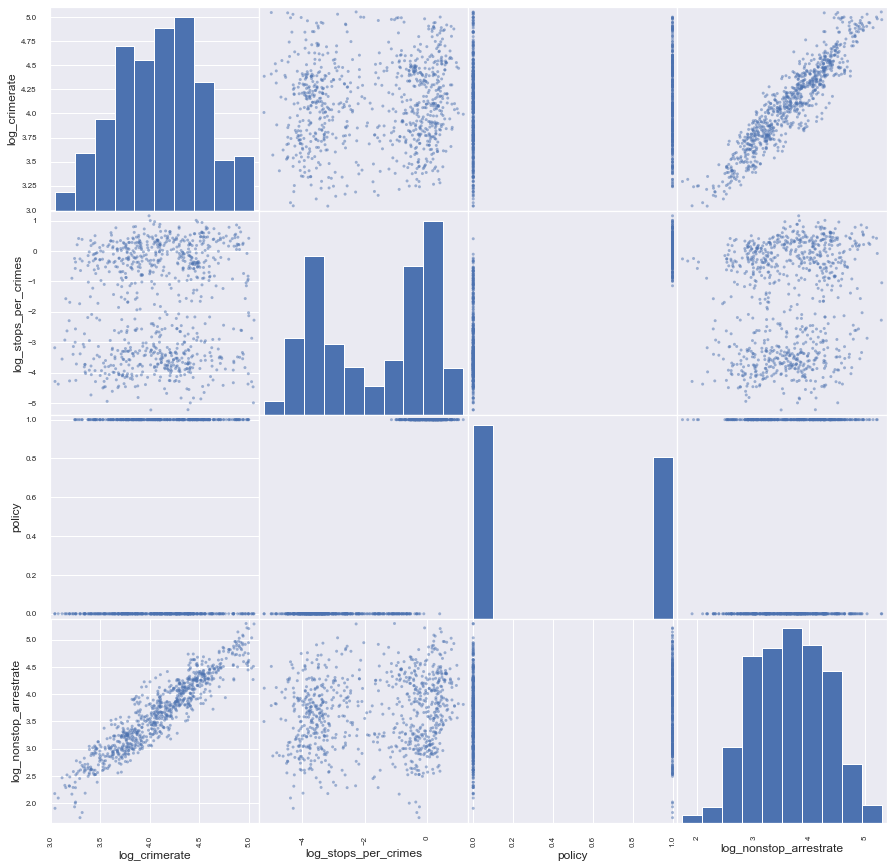

In [571]:
pd.plotting.scatter_matrix(df[['log_crimerate','log_stops_per_crimes','policy','log_nonstop_arrestrate']]);

In [523]:
x_vars = ['log_crimerate']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_nonstop_arrestrate   R-squared:                       0.864
Model:                                OLS   Adj. R-squared:                  0.864
Method:                     Least Squares   F-statistic:                     4124.
Date:                    Wed, 04 Dec 2019   Prob (F-statistic):          2.22e-283
Time:                            23:37:20   Log-Likelihood:                0.71546
No. Observations:                     651   AIC:                             2.569
Df Residuals:                         649   BIC:                             11.53
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.1326      0.091    -23.548      0.000      -2.310      -1.955
log_crimerate     1.4116      0.022     64.215      0.000       1.368       1.455
==============================================================================
Omnibus:                        4.026   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.694
Skew:                           0.050   Prob(JB):                       0.0956
Kurtosis:                       3.404   Cond. No.                         41.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [527]:
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.051982811492268105
Test Mean Squared Error: 0.0510067629187122


In [528]:
linreg.intercept_, linreg.coef_[0], linreg.score(X_train,y_train), linreg.score(X_test, y_test)

(-1.9596154282354576,
 1.3468494882005173,
 0.8793690634934188,
 0.880915759208918)

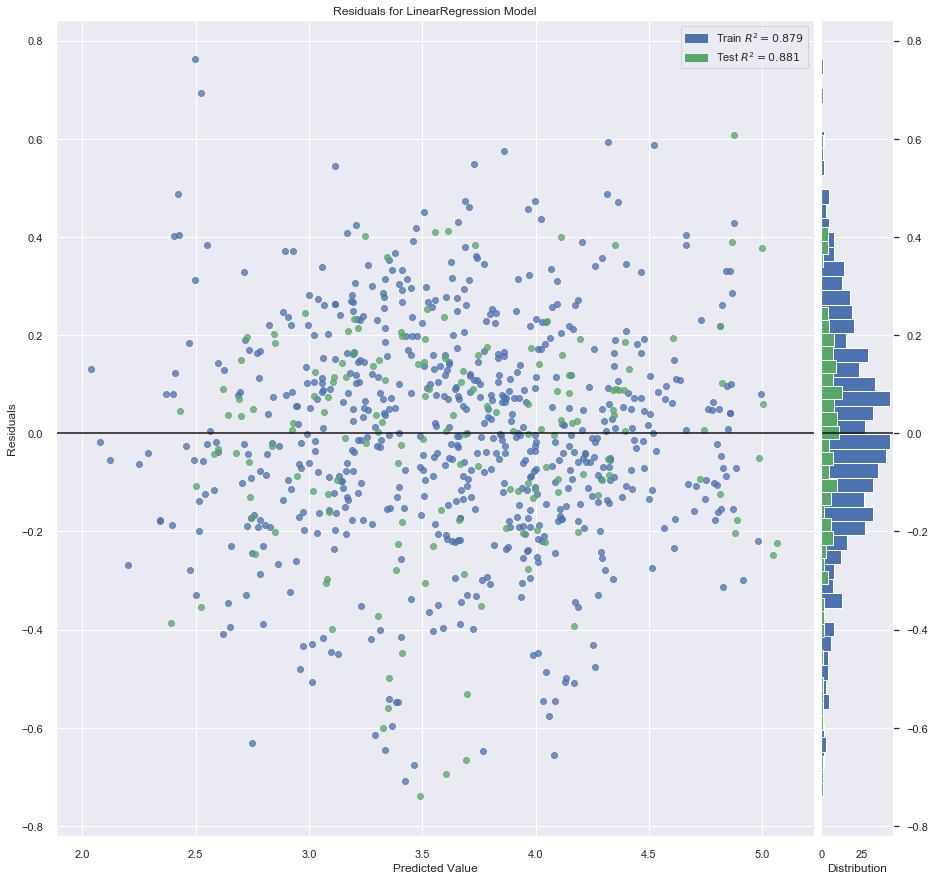

In [529]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

# RFE Cross-Validation

In [600]:
x_vars = ['log_crimerate','log_stoprate','policy','normal_year','log_stop_arrestrate','log_stops_per_crimes','log_population']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
results['result'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     log_nonstop_arrestrate   R-squared:                       0.890
Model:                                OLS   Adj. R-squared:                  0.889
Method:                     Least Squares   F-statistic:                     868.5
Date:                    Thu, 05 Dec 2019   Prob (F-statistic):          8.51e-305
Time:                            00:03:40   Log-Likelihood:                 51.938
No. Observations:                     651   AIC:                            -89.88
Df Residuals:                         644   BIC:                            -58.53
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9290      0.369     -5.227      0.000      -2.654      -1.204
log_crimerate            0.9216      0.019     48.604      0.000       0.884       0.959
log_stoprate             0.4957      0.014     35.381      0.000       0.468       0.523
policy                  -0.2578      0.039     -6.646      0.000      -0.334      -0.182
normal_year             -0.0077      0.007     -1.123      0.262      -0.021       0.006
log_stop_arrestrate      0.0102      0.018      0.556      0.578      -0.026       0.046
log_stops_per_crimes    -0.4259      0.012    -34.958      0.000      -0.450      -0.402
log_population           0.0045      0.025      0.179      0.858      -0.045       0.054
==============================================================================
Omnibus:                        7.950   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               10.338
Skew:                           0.121   Prob(JB):                      0.00569
Kurtosis:                       3.568   Cond. No.                     5.23e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.66e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [601]:
from sklearn import metrics

def run_model(model, X_train, X_test, y_train, y_test):
    print('Training R^2 :', model.score(X_train, y_train))
    y_pred_train = model.predict(X_train)
    print('Training Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print('\n----------------\n')
    print('Testing R^2 :', model.score(X_test, y_test))
    y_pred_test = model.predict(X_test)
    print('Testing Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

rfe = RFECV(LinearRegression(), cv=5)
X_rfe_train = rfe.fit_transform(X_train, y_train)
X_rfe_test = rfe.transform(X_test)
lm = LinearRegression().fit(X_rfe_train, y_train)
run_model(lm, X_rfe_train, X_rfe_test, y_train, y_test)
print('The optimal number of features is: ', rfe.n_features_)
print('Grid scores: ', rfe.grid_scores_)
print(X_train.columns)
rfe.ranking_

Training R^2 : 0.8897763558228734
Training Root Mean Square Error 0.22365557607398623

----------------

Testing R^2 : 0.8256620911308488
Testing Root Mean Square Error 0.24225860214985362
The optimal number of features is:  4
Grid scores:  [0.87479729 0.87929048 0.87929048 0.8874563  0.88671151 0.88629764
 0.88636355]
Index(['log_crimerate', 'log_stoprate', 'policy', 'normal_year',
       'log_stop_arrestrate', 'log_stops_per_crimes', 'log_population'],
      dtype='object')


array([1, 1, 1, 3, 2, 1, 4])

## VIF


In [382]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [586]:
x_vars = ['crimerate','stops_per_crimes','stop_arrestrate', 'policy','normal_year','population']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']

vif = [variance_inflation_factor(X_train.values, i) for i in range(0, X_train.shape[1])]
print(X_train.columns.to_list())
list(vif)

['crimerate', 'stops_per_crimes', 'stop_arrestrate', 'policy', 'normal_year', 'population']


[7.694365231607154,
 7.759664537833451,
 4.528665760701579,
 7.3352387996470245,
 8.929786098764202,
 6.426844211572975]

In [590]:
x_vars = ['log_crimerate','log_stops_per_crimes','log_stop_arrestrate','policy','normal_year','log_population']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']

vif = [variance_inflation_factor(X_train.values, i) for i in range(1, X_train.shape[1])]
print(X_train.columns.to_list())
list(vif)

['log_crimerate', 'log_stops_per_crimes', 'log_stop_arrestrate', 'policy', 'normal_year', 'log_population']


[27.00740213976608,
 8.878258549307207,
 9.313594658056513,
 27.756560664176995,
 112.6957428308041]

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

## PCA to reduce multicollinearity

In [303]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [591]:
x_vars = ['log_crimerate','log_stops_per_crimes','log_stop_arrestrate','policy','normal_year','log_population']
results = dm.run_ols(df, x_vars, 'log_nonstop_arrestrate')
X_train = results['data']['X_train'].copy()
X_test = results['data']['X_test'].copy()
y_train = results['data']['y_train']
y_test = results['data']['y_test']
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [592]:
pca = PCA(.95)
pca.fit(X_train)
pca.n_components_

4

In [593]:
pca.components_

array([[-0.14853979, -0.50456119, -0.49093583, -0.48675911,  0.48638858,
         0.09395567],
       [ 0.67297772, -0.14201403,  0.11005362, -0.14726844,  0.15424271,
        -0.68508569],
       [ 0.65963796, -0.0486117 ,  0.16074176, -0.08090911,  0.09279457,
         0.72216317],
       [ 0.25038454, -0.31081091, -0.65392177,  0.42191373, -0.48481865,
         0.00549121]])

In [594]:
pca.explained_variance_ratio_.sum()

0.9704045069077648

In [595]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [596]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.056548929089642846
Test Mean Squared Error: 0.055341516266338105


In [597]:
linreg.intercept_, linreg.coef_[0], linreg.score(X_train,y_train), linreg.score(X_test, y_test)

(3.646657983509579,
 -0.1115229895089986,
 0.8626274300164353,
 0.8900279715702464)

Text(0.5, 1.0, 'Linear Regression')

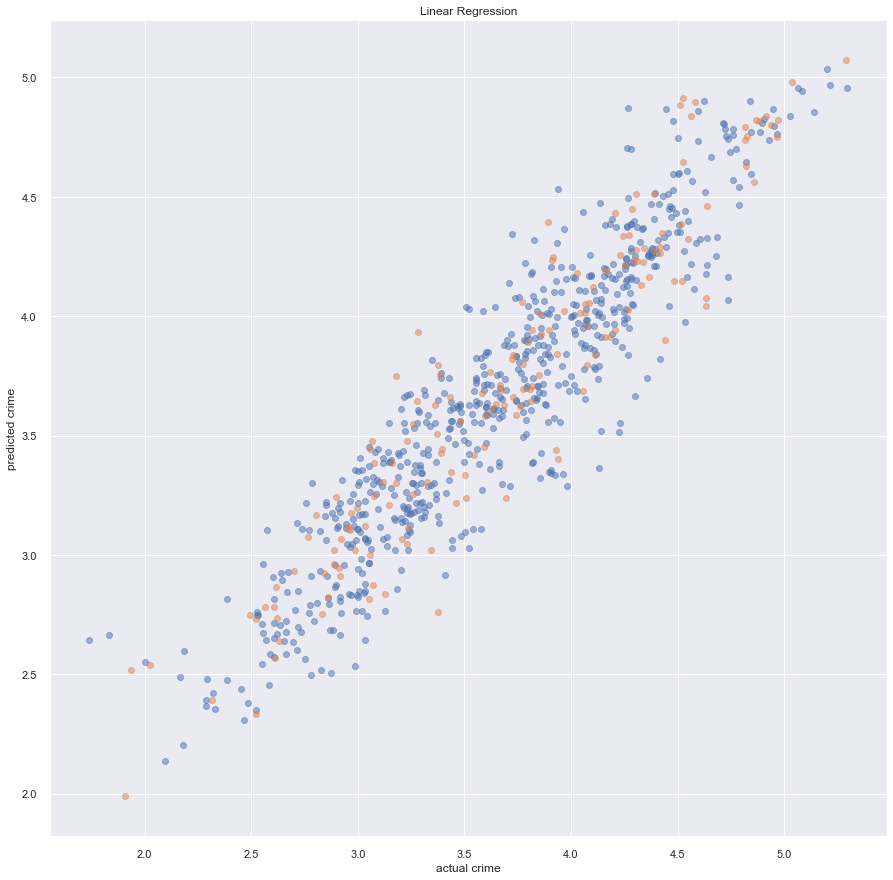

In [598]:
plt.scatter(y_train, linreg.predict(X_train), alpha=0.5)
plt.scatter(y_test, linreg.predict(X_test), alpha=0.5)
plt.xlabel('actual crime')
plt.ylabel('predicted crime')
plt.title('Linear Regression')

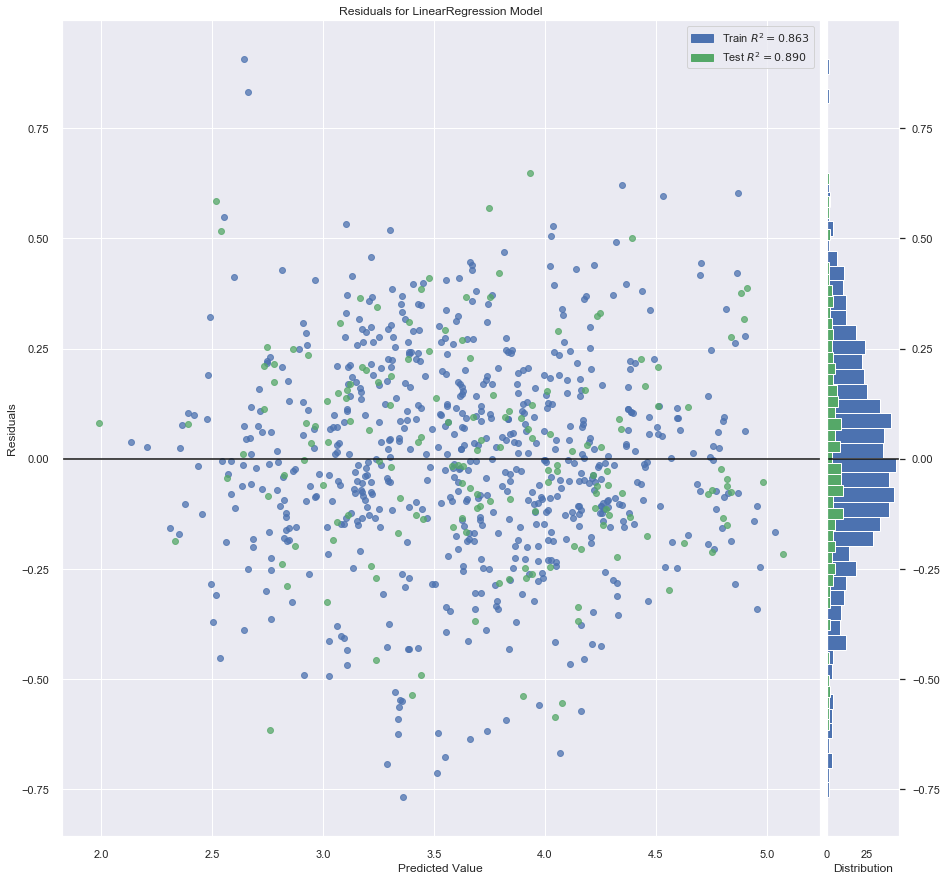

In [599]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Cross validation

In [ ]:
https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html

## Try interaction terms

In [26]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
poly.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X, y)

,year,pct,cmplnts,population,arrests,stops,stop_arrests
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0
...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0
